# Protein Structure Similarity

As per our [proposal](https://docs.google.com/document/d/16Q1unuf3kyJHJCy2vJs7K7GbkNf4OpMiPSRqJB1XyIg/), the goal of this project is to help accelerate research in human biology, pharmaceuticals, protein engineering and convergent structural evolution with a visualization tool to explore clustered [protein structure predictions](https://alphafold.ebi.ac.uk/) by DeepMind's AlphaFold. 
*  DeepMind [human protein structure predictions](https://alphafold.ebi.ac.uk/) database.
*  mmCIF [file format dictionary](https://mmcif.wwpdb.org/dictionaries/mmcif_pdbx_v40.dic/Index/index.html).
*  UnitProt [protein database](https://www.uniprot.org/).
*  Paper on [generating embeddings](https://academic.oup.com/bioinformatics/article/37/2/162/5892762) for deep learning from protein structure data.

## Understanding Structural Coordinates in the mmCIF Dictionary

*  [PDB101 article](https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/dealing-with-coordinates) on the subject. 

## Important Pre-Run Steps

* If you're using Colab, set `is_colab` to `True`. Otherwise, if you're running on JupyterLab in Cloud Dataproc, set it to `False`. Failing to set the bit appropriately will result in numerous errors.
  * On Colab you also need to load the service account key into local Colab storage before running the notebook. The key can be found in our [Capstone Drive](https://drive.google.com/file/d/1r_9Ew9iIHe86_hYyVi9fFpdDhy4h1Eic).

In [1]:
is_colab = True

# Install Packages & Run Imports

In [2]:
!pip install mmcif_pdbx
!pip install pandas-profiling

# mmCIF / Protein Libs
import pdbx
from pdbx.reader import PdbxReader
from pdbx.reader import DataContainer

# I/O Libs
from google.cloud import storage
import io
import os
from IPython.display import clear_output

# Data Manipulation Libs
import pandas as pd
import numpy as np
import math

# Viz Libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()

# ML Libs
from sklearn import preprocessing
from sklearn.cluster import KMeans

clear_output()

# Start Spark Context & Test MR

**Note:** Most of MLLib works with labeled examples, so thoughout this notebook we may use Spark Dataframes for exploratory analysis, but we should always move datasets slated for modeling into labeled examples. RDD test included below just for simplicity's sake. Commented out while we just do local work.

In [ ]:
#sc

In [ ]:
#rdd = (sc.parallelize(['lorem', 'ipsum', 'dolor', 'sit', 'amet', 'lorem'])
#       .map(lambda word: (word, 1))
#       .reduceByKey(lambda a, b: a + b))
#print(rdd.collect())

# Load Protein Data from GCS & Process

In [3]:
# Instantiates a client & loads credentials
if is_colab is True:
  os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/PSS GCS Storage Key.json"
storage_client = storage.Client()

In [4]:
result = []
stats = [0, 0]

for blob in storage_client.get_bucket('capstone-fall21-protein').list_blobs():
    data=[]
    stats[0] += 1

    if is_colab is True:
      txt = io.StringIO(blob.download_as_string().decode("utf-8"))
    else:
      txt = io.StringIO(blob.download_as_text())

    pRd = PdbxReader(txt)
    pRd.read(data)
    txt.close()
    block = data[0]

    obj = block.get_object("atom_site")
    
    for row in obj.get()[2]:
        result.append(row)
    stats[1] += len(obj.get()[2])

print(f'Processed {stats[0]} proteins ({stats[1]} rows)')

Processed 50 proteins (121589 rows)


In [5]:
atoms = pd.DataFrame(data=result, columns=obj.item_name_list, dtype=float)
atoms.sample(5)

,_atom_site.group_PDB,_atom_site.id,_atom_site.type_symbol,_atom_site.label_atom_id,_atom_site.label_alt_id,_atom_site.label_comp_id,_atom_site.label_asym_id,_atom_site.label_entity_id,_atom_site.label_seq_id,_atom_site.pdbx_PDB_ins_code,_atom_site.Cartn_x,_atom_site.Cartn_y,_atom_site.Cartn_z,_atom_site.occupancy,_atom_site.B_iso_or_equiv,_atom_site.pdbx_formal_charge,_atom_site.auth_seq_id,_atom_site.auth_comp_id,_atom_site.auth_asym_id,_atom_site.auth_atom_id,_atom_site.pdbx_PDB_model_num,_atom_site.pdbx_sifts_xref_db_acc,_atom_site.pdbx_sifts_xref_db_name,_atom_site.pdbx_sifts_xref_db_num,_atom_site.pdbx_sifts_xref_db_res
95312,ATOM,5243.0,C,CB,,ARG,A,1.0,704.0,NaN,-10.513,6.042,-8.668,1.0,84.31,NaN,704.0,ARG,A,CB,1.0,Q96JQ0,UNP,1104.0,R
95939,ATOM,5870.0,C,CG,,GLN,A,1.0,784.0,NaN,-11.662,15.632,-17.551,1.0,90.82,NaN,784.0,GLN,A,CG,1.0,Q96JQ0,UNP,1184.0,Q
16115,ATOM,958.0,C,CB,,SER,A,1.0,125.0,NaN,-17.860,6.061,11.358,1.0,97.79,NaN,125.0,SER,A,CB,1.0,A0A0G2JN68,UNP,125.0,S
115421,ATOM,1452.0,C,C,,LEU,A,1.0,180.0,NaN,4.235,13.005,5.254,1.0,95.77,NaN,180.0,LEU,A,C,1.0,U3KPV4,UNP,180.0,L
46441,ATOM,2517.0,N,NE,,ARG,A,1.0,307.0,NaN,-38.925,39.861,19.951,1.0,91.64,NaN,307.0,ARG,A,NE,1.0,O95613,UNP,907.0,R


In [6]:
def feature_report(col):
  print(f'FEATURE: {col.name}\n'
        f'  Min/Max:   {min(col)}, {max(col)}')
  if col.dtype == 'float64':
    print(f'  Mean/Med.: {col.mean():.4f}, {col.median():.4f}')
  else:
    print(f'  Most Freq.:{col.value_counts().index[0]} ({col.value_counts()[0]})')
  print(f'  Unique:    {col.nunique()}\n'
        f'  Empty:     {col.isna().sum() + (col == "").sum()}\n'
        f'  Sample:    {list(col.sample(3))}\n')      

#for feature in atoms.columns:
#    feature_report(atoms[feature])

# Experiment 1 - Focus on atom cartesian coordinates only

First, let's take a look at our data as-is: 1 row = 1 atom's (X, Y, Z) position, for all proteins. We'll cluster these using K-Means.

In [7]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)

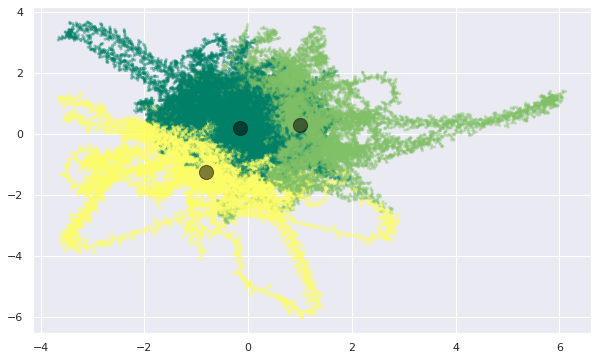

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.predict(X)

figure(figsize=(10,6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# TODO: 3D viz

Aside from demonstrating that we can succesfully cluster and plot our single-atom-level data (yay us?), this isn't super meaningful. **TODO:** Consider single atom level clustering on all atoms of all proteins after the main project goals are met. It may be interesting to see whether there are patterns int he spatial layout of amino acid atoms across the entire human proteome.

Next, we move on to the main proof-of-concept we'll need to create our target data structure: a vector of all member atom cartesian coordinates for each protein we process. We'll isolate our columns of interest, scale them, and then add a new column that contains a list in the form [X coord, Y coord, Z coord] for each atom.

In [9]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)
X = pd.DataFrame(X, columns=['x', 'y', 'z'])
X['vect'] = X.values.tolist()
X.drop(['x', 'y', 'z'], axis=1, inplace=True)
X.head()

,vect
0,"[1.446995485804857, 1.112442410380177, -1.4107..."
1,"[1.4229658652317276, 1.0615505575753468, -1.39..."
2,"[1.379106557768662, 1.0802886122813604, -1.395..."
3,"[1.4370356430704263, 1.0424606145180464, -1.35..."
4,"[1.3695667084025507, 1.1223832563040246, -1.37..."


Next we append the protein names and group our data by them, appending each atom's coordinate list to eachother to form a single atom-coordinate vector per protein. Because we're still on a K-Means kick, we need our vectors all to be of the same length. Right now they're variable as each protein has a different number of atoms in it. To fix this we pad each vector with 0's to extend it to the length of the longest vector in our dataset. We then split those vectors into columns (holy sparse array, Batman!), switch over to a Numpy array and run K-Means.

In [10]:
X['protein'] = atoms['_atom_site.pdbx_sifts_xref_db_acc']

In [11]:
proc = pd.DataFrame(X.groupby(['protein']).sum(['vect'])).reset_index()

In [12]:
max_len = 0

for v in proc.vect:
    if len(v) > max_len:
        max_len = len(v)
        
i = 0

for p in proc.protein:
    v = proc[proc.protein == p].vect[i]
    i += 1
    v.extend([0.0] * (max_len - len(v)))
    proc[proc.protein == p].vect[i] = v

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
df3 = pd.DataFrame(proc['vect'].to_list())
ar1 = df3.to_numpy()

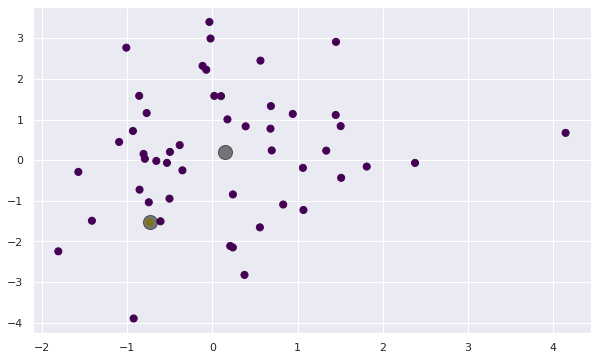

In [14]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(ar1)
y_kmeans = kmeans.predict(ar1)

figure(figsize=(10,6))
plt.scatter(ar1[:, 0], ar1[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Depending on when you look at this, the result may be pretty disappointing. At time of writing we are only using a sample of 30 proteins (out of 23,391), so we expect little in the way of clustering. Still, as a proof on concept for the project, it works!

# Scratch Code & Notes

In [ ]:
atoms_norm = atoms.copy(deep=True)
atoms_norm.to_numpy()

num_cols = [col for col in atoms_norm.columns if atoms_norm[col].dtype == float]
cat_cols = [col for col in atoms_norm.columns if col not in num_cols]

# Ordinal encode categorical features & standardize everything
enc = preprocessing.OrdinalEncoder()
atoms_norm[cat_cols] = enc.fit(atoms_norm[cat_cols]).transform(atoms_norm[cat_cols])
atoms_norm = preprocessing.StandardScaler().fit(atoms_norm).transform(atoms_norm)

atoms_norm